In [1]:
sys.path.append(os.path.abspath('./../../'))
from cell_extractor.CellDetector import MultiThresholdDetector
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os,sys
from scipy.spatial import distance_matrix
sys.path.append(os.path.abspath('./../../'))
from Controllers.MarkedCellController import MarkedCellController
from Controllers.SqlController import SqlController
from model.annotation_points import MarkedCellView
from sqlalchemy import inspect
inst = inspect(MarkedCellView)
attr_names = [c_attr.key for c_attr in inst.mapper.column_attrs]
import pandas as pd
from cell_extractor.DetectorMetrics import AnnotationProximityTool
import numpy as np
from collections import Counter
user_look_up = {38:'Marissa',41:'Julian'}
from cell_extractor.CellAnnotationUtilities import CellAnnotationUtilities

def get_DataFrame_from_query_result(results,category,factor):
    values = []
    for i in results:
        source = i.source.value
        if '-' in source:
            source = source.split('-')[1]    
        x,y,z = np.array([i.x,i.y,i.z]).astype(float)/factor
        values.append([x,y,z,f'{category}_{user_look_up[i.FK_annotator_id]}_{source}'])
    # values = [[eval(f'j.{i}')  for j in results ] for i in attr_names]
    pd.DataFrame(dict(zip(['x','y','section','name'],np.array(values).T))).head()
    df = pd.DataFrame(dict(zip(['x','y','section','name'],np.array(values).T)))
    df["x"] = pd.to_numeric(df["x"])
    df["y"] = pd.to_numeric(df["y"])
    df["section"] = pd.to_numeric(df["section"])
    return df

def find_equivalence(points):
    tool = AnnotationProximityTool()
    tool.pair_distance=0.1
    tool.set_annotations_to_compare(points)
    tool.find_equivalent_points()
    return tool

def find_agreement(tool,agree,disagree):
       agreed = []
       disagreed = []
       for id,group in tool.pairs.items():
              if tool.pair_categories[id] in agree:
                     agreed.append(tool.annotations_to_compare.iloc[group[0]])
              elif tool.pair_categories[id] in disagree:
                     disagreed.append(tool.annotations_to_compare.iloc[group[0]])
       agreed = pd.concat(agreed,axis=1).T
       disagreed = pd.concat(disagreed,axis=1).T
       return agreed,disagreed
def print_unique_combination(tool):
    dictionary = []
    for i in tool.pair_categories.values():
        if not i in dictionary:
            dictionary.append(i)
    for key,val in dictionary.items():
        print(key,val)

In [2]:
animali = 'DK41'
detector = MultiThresholdDetector(animali,round = 2)
sures = detector.get_sures()
unsures = detector.get_unsures()

In [142]:
controller = SqlController()
factor = controller.get_resolution(animali)
controller = MarkedCellController()
search_dict = {'FK_prep_id':animali,'FK_cell_type_id':11}
round3_sures = get_DataFrame_from_query_result(controller.get_marked_cells(search_dict),'Sure',factor)
round3_sures_tool = find_equivalence(round3_sures)
search_dict = {'FK_prep_id':animali,'FK_cell_type_id':12}
round3_unsures = get_DataFrame_from_query_result(controller.get_marked_cells(search_dict),'Unsure',factor)
round3_unsures_tool = find_equivalence(round3_unsures)
search_dict = {'FK_prep_id':animali,'FK_cell_type_id':13}
connected = get_DataFrame_from_query_result(controller.get_marked_cells(search_dict),'Connected',factor)
connected_tool = find_equivalence(connected)
search_dict = {'FK_prep_id':animali,'FK_cell_type_id':14}
false_negatives = get_DataFrame_from_query_result(controller.get_marked_cells(search_dict),'False_negative',factor)
false_negatives_tool = find_equivalence(false_negatives)


calculating distance matrix
finding points that are close to each other
grouping and labeling points that are close to each other
before removing duplicates 1000
after removing duplicates 500
calculating distance matrix
finding points that are close to each other
grouping and labeling points that are close to each other
before removing duplicates 8982
after removing duplicates 4491
calculating distance matrix
finding points that are close to each other
grouping and labeling points that are close to each other
before removing duplicates 43
after removing duplicates 43
calculating distance matrix
finding points that are close to each other
grouping and labeling points that are close to each other
before removing duplicates 917
after removing duplicates 914


In [147]:
agree = [['Sure_Marissa_NEGATIVE', 'Sure_Julian_NEGATIVE'],
        ['Sure_Marissa_NULL', 'Sure_Julian_NEGATIVE'],
        ['Sure_Marissa_POSITIVE', 'Sure_Julian_POSITIVE']]
disagree = [
        ['Sure_Marissa_NEGATIVE', 'Sure_Julian_POSITIVE'],
        ['Sure_Marissa_NULL', 'Sure_Julian_POSITIVE'],
        ['Sure_Marissa_POSITIVE', 'Sure_Julian_NEGATIVE']]
sure_agreed,sure_disagreed = find_agreement(round3_sures_tool,agree,disagree)
agree = [['Unsure_Marissa_NULL', 'Unsure_Julian_NULL'],
 ['Unsure_Marissa_NEGATIVE', 'Unsure_Julian_NEGATIVE'],
 ['Unsure_Marissa_POSITIVE', 'Unsure_Julian_POSITIVE'],]
disagree = [['Unsure_Marissa_NEGATIVE', 'Unsure_Julian_POSITIVE'],
 ['Unsure_Marissa_NEGATIVE', 'Unsure_Julian_NULL'],
 ['Unsure_Marissa_POSITIVE', 'Unsure_Julian_NEGATIVE'],
 ['Unsure_Marissa_POSITIVE', 'Unsure_Julian_NULL']]
unsure_agreed,unsure_disagreed = find_agreement(round3_unsures_tool,agree,disagree)
agree = [['False_negative_Julian_POSITIVE', 'False_negative_Marissa_POSITIVE'],]
disagree = [['False_negative_Julian_POSITIVE'],
 ['False_negative_Marissa_POSITIVE']]
false_negatives_agreed,false_negatives_disagreed = find_agreement(false_negatives_tool,agree,disagree)

In [226]:
sure_points = np.array([sures.x,sures.y,sures.section]).T.astype(float)
unsure_points = np.array([unsures.x,unsures.y,unsures.section]).T.astype(float)
sure_agreed_points = np.array([sure_agreed.x,sure_agreed.y,sure_agreed.section]).T.astype(float)
unsure_agreed_points = np.array([unsure_agreed.x,unsure_agreed.y,unsure_agreed.section]).T.astype(float)
sure_disagreed_points = np.array([sure_disagreed.x,sure_disagreed.y,sure_disagreed.section]).T.astype(float)
unsure_disagreed_points = np.array([unsure_disagreed.x,unsure_disagreed.y,unsure_disagreed.section]).T.astype(float)
util = CellAnnotationUtilities()
ids = util.find_cloest_neighbor_among_points(sure_points,sure_agreed_points)
sure_aggreed_features = sures.iloc[ids]
ids = util.find_cloest_neighbor_among_points(sure_points,sure_disagreed_points)
sure_disaggreed_features = sures.iloc[ids]
ids = util.find_cloest_neighbor_among_points(unsure_points,unsure_agreed_points)
unsure_aggreed_features = unsures.iloc[ids]
ids = util.find_cloest_neighbor_among_points(unsure_points,unsure_disagreed_points)
unsure_disaggreed_features = unsures.iloc[ids]

skipping, min distance 28.727740546778378
skipping, min distance 20.3214172734078


In [228]:
len(unsure_points),len(unsure_agreed_points),len(unsure_disagreed_points)

(15826, 4412, 79)

Text(0.5, 1.0, '')

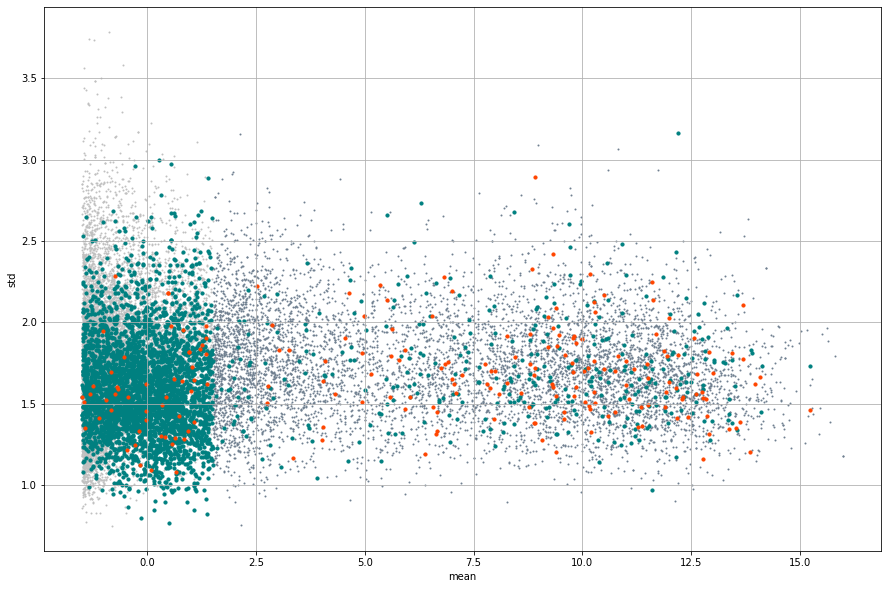

In [223]:

plt.figure(figsize=[15,10])
plt.scatter(sures['mean'].to_numpy(),sures['std'].to_numpy(),color='slategrey',s=1)
plt.scatter(sure_aggreed_features['mean'].to_numpy(),sure_aggreed_features['std'].to_numpy(),color='teal',s=10,)
plt.scatter(sure_disaggreed_features['mean'].to_numpy(),sure_disaggreed_features['std'].to_numpy(),color='orangered',s=10)
plt.scatter(unsures['mean'].to_numpy(),unsures['std'].to_numpy(),color='silver',s=1)
plt.scatter(unsure_aggreed_features['mean'].to_numpy(),unsure_aggreed_features['std'].to_numpy(),color='teal',s=10,)
plt.scatter(unsure_disaggreed_features['mean'].to_numpy(),unsure_disaggreed_features['std'].to_numpy(),color='orangered',s=10)
plt.title('mean and std of scores for 30 classifiers')
plt.xlabel('mean')
plt.ylabel('std')
plt.grid()
plt.title('')

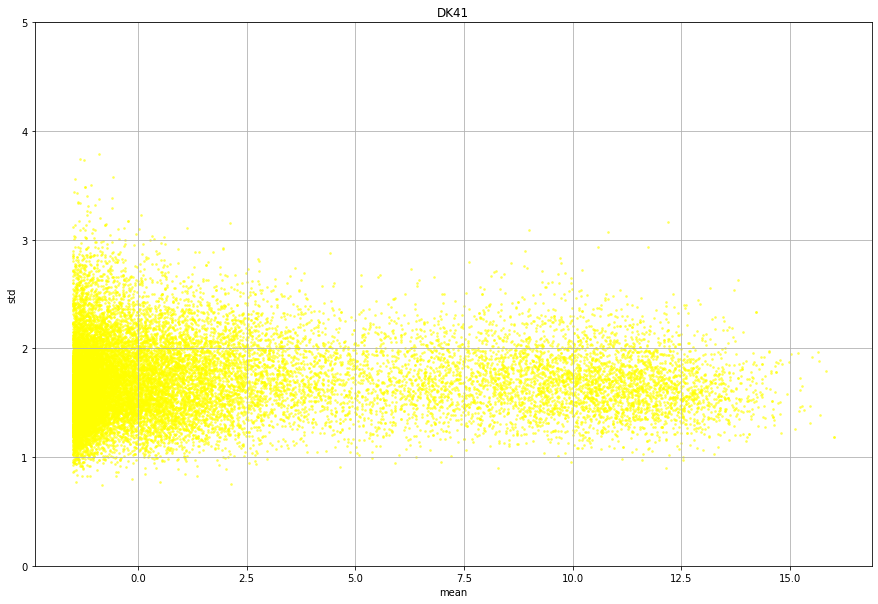

In [3]:
animali = 'DK41'
lower = 0
upper = 5
detector = MultiThresholdDetector(animali,round = 2)
detections = detector.load_detections()
detections = detections[[string_to_prediction(i) != -2 for i in detections.name]]

detector.detector.mean = detections['mean'].to_numpy()
detector.detector.std = detections['std'].to_numpy()
detector.detector.labels = detections['label'].to_numpy()
detector.detector.predictions = [string_to_prediction(i) for i in detections.name]
detector.detector.plot_score_scatter([],color1 = 'black',color2 = 'yellow',lower_lim= lower,upper_lim= upper,title = animali,alpha1 = 0.5,alpha2 = 0.5)